## 0.0 Entender o problema

-- Objetivo do problema:
    -- 1.0 Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Porque?
      --Qual tipo de modelo de negócio do Airbnb?
        --Marketplace (Conectar pessoas que oferecem acomodação, com as pessoas que estão procurando acomodação).
        
        --Oferta (pessoas oferecendo acomodação)
            --Tamanho do Portfólio.
            -- diversidade/Densidade de Portfólio.
            --Preço médio
        
        --Demanda (pessoa procurando acomodação)
             --Número de Usuários 
             --LTV (LifeTime Value)
             --CAC (Client Aquisition Cost)
        
        Gross Revenue = (Fee * Numero de clientes) - CAC
        
        --Demanda (pessoas procurando acomodação)
        
        
--Proposta da solução:

    --- Modelo de previsão do primeiro destino de um novo usuário.
    
    --- 1.0 Predições e salvar em uma tabela de bando de dados.
    
    ---2.0 Criar uma API
        --- Input: usuario  e suas caracteristicas
        --- Output: usuario e suas caracteristicas com a ** predição do destino**.

        
        

# 0.0 <font color ='red'>Ciclo01: End to End </font>

# 0.0 Imports

In [1]:
!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt
import sklearn.model_selection

from keras import models as ml
from keras import layers as l


# 0.1 Helper functions

# 0.2 Loading Data

In [3]:
# datasets source: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data?select=sessions.csv.zip


df_raw = pd.read_csv('dataset/training_users_2.csv', low_memory=True)
df_raw.shape

df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
print( 'Number of rows: {}'.format(df1.shape[0] ) )
print( 'Number of columns: {}'.format(df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


## 1.1 Data type

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.2 NA Check

In [7]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [8]:
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.3 Change Data Type

In [9]:
# date_account_created    
df1["date_account_created"] = pd.to_datetime( df1["date_account_created"] )

# timestamp_first_active   
df1["timestamp_first_active"] = pd.to_datetime( df1["timestamp_first_active"], format='%Y%m%d%H%M%S' )

# date_first_booking       
df1["date_first_booking"] = pd.to_datetime( df1["date_first_booking"] )

# age       
df1["age"] = df1["age"].astype( int )

In [10]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.4 Check Balanced Data

In [11]:
df1["country_destination"].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0 Data filtering

In [12]:
df2 = df1.copy()

# 2.1 Filtering Rows

# 2.1 Columns Selection

# 3.0 Data Preparation

In [13]:
df3 = df2.copy()

In [14]:
#dummies variables.
df3_dummy = pd.get_dummies(df3.drop( ['id','country_destination'], axis=1) )

# join id and country destination
df3 = pd.concat( [df3[["id","country_destination"]],df3_dummy], axis=1 )  
                     

# 4.0 Feature Selecion

In [15]:
cols_drop = ["date_account_created", "timestamp_first_active","date_first_booking" ] # original dates
df4 = df3.drop(cols_drop, axis=1)

In [16]:
df4.sample().T

,23165
id,ot3s8jlm8y
country_destination,US
age,49
signup_flow,0
gender_-unknown-,0
...,...
first_browser_Sogou Explorer,0
first_browser_Stainless,0
first_browser_TenFourFox,0
first_browser_TheWorld Browser,0


In [17]:
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [18]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 5.0 Machine Learning - Neural Network - MLP

In [19]:
x_train = X_train.drop("id", axis=1)
x_test = X_test.drop("id", axis=1)
x_train.shape[1]

112

## 5.1. Baseline Model 

In [20]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
# adding the weights according to column distribution "country_destination"
country_destination_weights= df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# random model

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights,              
                             k=k_num)
len(yhat_random)

13635

## 5.1.1 Baseline Model Performance

Accuracy: 0.5187385405207188
Balanced Accuracy: 0.08866831645005939
Kappa Score: 0.08866831645005939
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.02      0.02      0.02       214
          DE       0.01      0.01      0.01       170
          ES       0.03      0.03      0.03       345
          FR       0.04      0.04      0.04       710
          GB       0.02      0.02      0.02       344
          IT       0.03      0.03      0.03       423
          NL       0.01      0.01      0.01       128
          PT       0.00      0.00      0.00        36
          US       0.70      0.71      0.71      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.51      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

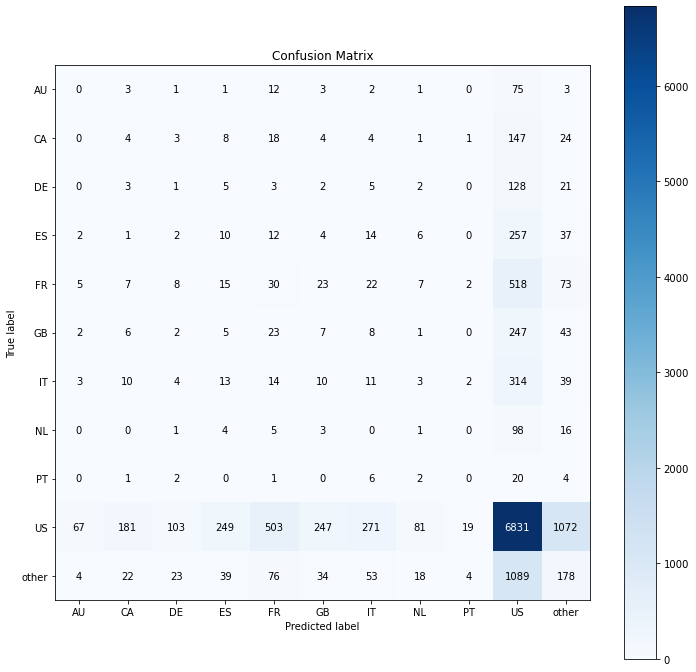

In [21]:
# Acurracy
acc_random = m.accuracy_score(y_test, yhat_random )
print("Accuracy: {}".format(acc_random))

# Balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print("Balanced Accuracy: {}".format(balanced_acc_random))

#Kappa Metrics
Kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print("Kappa Score: {}".format(balanced_acc_random))

#Classification report
print(m.classification_report(y_test, yhat_random))


# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12) )

# 5.0 Neural Network - MLP

In [22]:
# One Hot Encoder
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1) ).toarray()

In [23]:
y_train_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [28]:
# model definition
model = ml.Sequential()
model.add(l.Dense( 128,input_dim=x_train.shape[1], activation='relu') )
model.add(l.Dense(11, activation="softmax") )

# model compile
model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )

model.fit( x_train, y_train_nn, epochs=100, verbose=0)

In [33]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

## 5.2.2 NN Performance

Accuracy: 0.703997066373304
Balanced Accuracy: 0.09237686486473459
Kappa Score: 0.0023825516878950292


C:\Users\jonys.arcanjo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonys.arcanjo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jonys.arcanjo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.33      0.01      0.02       170
          ES       0.00      0.00      0.00       345
          FR       0.25      0.00      0.01       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.20      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.14      0.09      0.08     13635
weighted avg       0.54      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

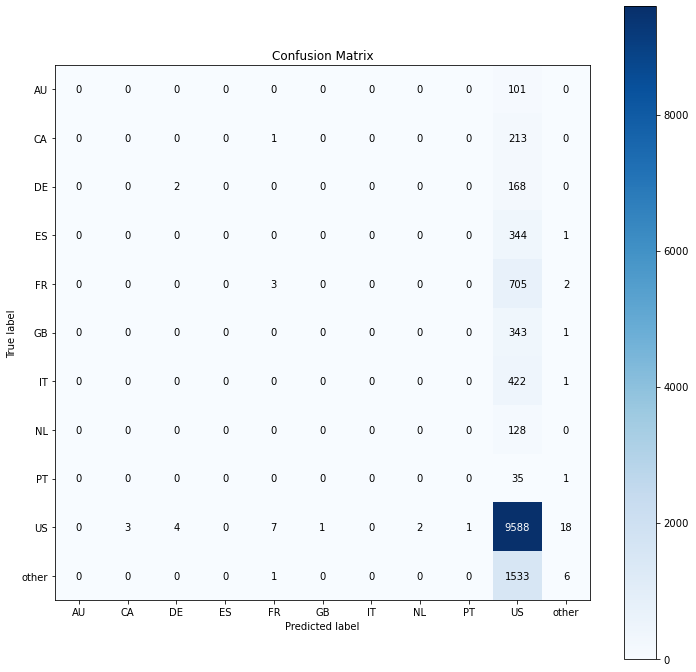

In [34]:
# Acurracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn )
print("Accuracy: {}".format(acc_nn))

# Balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print("Balanced Accuracy: {}".format(balanced_acc_nn))

#Kappa Metrics
Kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print("Kappa Score: {}".format(Kappa_nn))

#Classification report
print(m.classification_report(y_test_nn, yhat_nn))


# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12) )
#

## 5.2.3 NN Performance - Crsso Validation

In [35]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_nn_list =[]
Kappa_nn_list = []
i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print("fold number: {}/{}".format(i, num_folds))
          
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding --> categorical to numeral
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # model defition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation="relu"))
    model.add(l.Dense(11, activation="softmax"))

    # compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn) # numeral to categorical


    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    Yhat_nn = yhat_nn.reshape(-1, 1)[0]

    # metrics

    # Balanced accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_nn_list.append(balanced_acc_nn)
    #print("Balanced Accuracy: {}".format(balanced_acc_nn))

    #Kappa Metrics
    Kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    Kappa_nn_list.append(Kappa_nn)
    #print("Kappa Score: {}".format(Kappa_nn))

    i += 1

fold number: 1/5
fold number: 2/5
fold number: 3/5
fold number: 4/5
fold number: 5/5


In [36]:
print("avg Balanced Accuracy: {} +/- {}".format(np.mean(balanced_acc_nn_list), np.std(balanced_acc_nn_list)))
print("avg Kappa score: {} +/- {}".format(np.mean(Kappa_nn_list), np.std(Kappa_nn_list)))

avg Balanced Accuracy: 0.0914559061436516 +/- 0.0003675820975187182
avg Kappa score: 0.0029612108477728993 +/- 0.0011983818016539159
